In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.rcParams['figure.figsize'] = 9, 6
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/Users/brettnaul/miniconda3/envs/deep/lib/python3.6/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
from keras import backend as K
#K.set_learning_phase(0)
%run asas_full.py 64 2 0.25 --no_train --model_type gru --lr 1e-3 --sim_type asas_full/n200 --nb_epoch 50 --n_min 200 --n_max 200 --embedding 64
# --filter_length 7 --batch_norm

Using TensorFlow backend.


Skipping PhasedLSTM...
Skipping PhasedLSTM...
[]
/Users/brettnaul/Dropbox/Documents/timeflow/keras_logs/asas_full/n200/gru_064_x2_1m03_drop25_emb64
Loading /Users/brettnaul/Dropbox/Documents/timeflow/keras_logs/asas_full/n200/gru_064_x2_1m03_drop25_emb64/weights.h5...


# Visualizing predictions

In [3]:
%%time
pred = model.predict({'main_input': X, 'aux_input': np.delete(X, 1, axis=2)})

CPU times: user 35min 56s, sys: 10min 59s, total: 46min 56s
Wall time: 13min 57s


In [6]:
i = -1

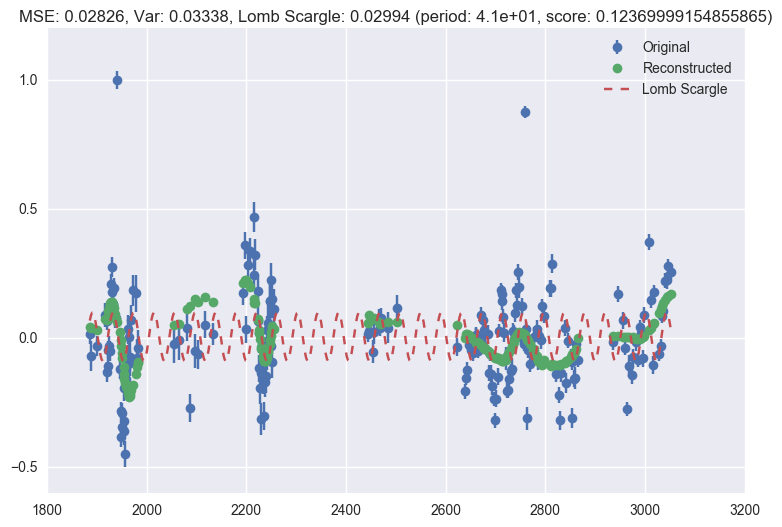

In [79]:
#inds = ~np.isnan(X_raw[i, :, 0])
inds = np.arange(args.n_min)
i += 1
#i = np.random.choice(inds)
t = X_raw[i, inds, 0]
m = X[i, inds, 1]
#m = np.random.normal(size=len(t))
e = X_raw[i, inds, 2]

plt.errorbar(t, m, e, None, 'o');
#plt.plot(t, pred[i], 'o');
plt.errorbar(t, pred[i], None, None, 'o');

from gatspy.periodic import LombScargleFast
model_gat = LombScargleFast(fit_period=True, optimizer_kwds={'period_range': (0.001 * (t.max() - t.min()), 0.95 * (t.max() - t.min())), 'quiet': True}, silence_warnings=True)
model_gat.fit(t, m, e)
m_gat = model_gat.predict(t, period=model_gat.best_period)
T = np.linspace(t.min(), t.max(), 501)
M_gat = model_gat.predict(T, period=model_gat.best_period)
plt.errorbar(T, M_gat, None, None, '--')

plt.legend(['Original', 'Reconstructed', 'Lomb Scargle'])
plt.title(f"MSE: {np.mean((m - np.squeeze(pred[i])) ** 2):1.4}, Var: {np.var(m):1.4}, "
          f"Lomb Scargle: {np.mean((m - m_gat) ** 2):1.4} (period: {model_gat.best_period:.2}, score: {model_gat.score(model_gat.best_period).item()})");

In [38]:
np.mean((m - m_gat) ** 2)

0.060711044365641731

# Visualizing training progress

# New data

In [ ]:
np.random.seed(0)

train = np.sort(np.random.choice(np.arange(len(X)), int(len(X) * 0.8), replace=False))
valid = np.arange(len(X))[~np.in1d(np.arange(len(X)), train)]
y = np.argmax(Y, axis=1)
_, scale_params = preprocess(X_raw, args.m_max, True, True, True)

In [ ]:
encode_layer = [l for l in model_full.layers if l.name == 'encoding'][0]
inputs = [l for l in model_full.layers if 'Input' in str(l)]
encode = K.function([inputs[0].input, inputs[1].input], [encode_layer.output])
encoding, = encode([X, X[:, :, 0:1]])
encoding.shape

In [ ]:
encoding = np.c_[encoding, scale_params['means'], scale_params['scales']]

In [ ]:
i = -1

In [ ]:
inds = ~np.isnan(X_raw[i, :, 0])
#inds = np.arange(args.n_min)
i += 1
#i = np.random.choice(inds)
t = X_raw[i, inds, 0]
m = X[i, inds, 1]
#m = np.random.normal(size=len(t))
e = X_raw[i, inds, 2]

plt.errorbar(t, m, e, None, 'o');
#plt.plot(t, pred[i], 'o');
#plt.errorbar(t, pred[i], None, None, 'o');

from gatspy.periodic import LombScargleFast
gat_resids = np.zeros(len(X))
model_gat = LombScargleFast(fit_period=True, optimizer_kwds={'period_range': (0.001 * (t.max() - t.min()), 0.95 * (t.max() - t.min())), 'quiet': True}, silence_warnings=True)
model_gat.fit(t, m)
print("Best period: {} (Score: {})".format(model_gat.best_period, model_gat.score(model_gat.best_period).item()))

#w_r, A_r, phi_r, b_r = pred_gru[i]
#x_r = A_r * np.sin(2 * np.pi * w_r * t + phi_r) + b_r
#plt.plot(t, x_r, '--')

plt.legend(['Original'])
plt.title("i={} ({})".format(i, classnames[y[i]]))

In [ ]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV

#enc_train, enc_test, y_train, y_test = train_test_split(encoding, y, test_size=0.25, random_state=42)
enc_train = encoding[train]; y_train = y[train]
enc_test = encoding[test]; y_train = y[test]

#asas_model = RandomForestClassifier(n_estimators=128)
asas_model = GridSearchCV(RandomForestClassifier(), {'n_estimators': [100, 250], 'criterion': ['gini', 'entropy'], 'max_features': [0.1, 0.2, 0.3]})
#asas_model = SVC()
asas_model.fit(enc_train, y_train)

In [ ]:
print("Training score: {}%".format(100 * asas_model.score(enc_train, y_train)))
print("Test score: {}%".format(100 * asas_model.score(enc_test, y_test)))

# Direct classifier

In [ ]:
%run asas 64 2 0.25 --model_type gru --lr 1e-3 --sim_type asas/n200 --nb_epoch 25 --n_min 200 --n_max 200 --m_max 32

# Light curve database